In [1]:
from evo.tools import log
log.configure_logging()

In [2]:
from evo.tools import plot
from evo.tools.plot import PlotMode
from evo.core.metrics import PoseRelation, Unit
from evo.tools.settings import SETTINGS

# temporarily override some package settings
SETTINGS.plot_figsize = [6, 6]
SETTINGS.plot_split = True
SETTINGS.plot_usetex = False

# magic plot configuration
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
%matplotlib widget

In [3]:
# interactive widgets configuration
import ipywidgets

check_opts_ape = {"align": False, "correct_scale": False, "show_plot": True}
check_boxes_ape=[ipywidgets.Checkbox(description=desc, value=val) for desc, val in check_opts_ape.items()]
check_opts_rpe = {"align": False, "correct_scale": False, "all_pairs": False, "show_plot": True}
check_boxes_rpe=[ipywidgets.Checkbox(description=desc, value=val) for desc, val in check_opts_rpe.items()]
delta_input = ipywidgets.FloatText(value=1.0, description='delta', disabled=False, color='black')
delta_unit_selector=ipywidgets.Dropdown(
    options={u.value: u for u in Unit if u is not Unit.seconds},
    value=Unit.frames, description='delta_unit'
)
plotmode_selector=ipywidgets.Dropdown(
    options={p.value: p for p in PlotMode},
    value=PlotMode.xy, description='plot_mode'
)
pose_relation_selector=ipywidgets.Dropdown(
    options={p.value: p for p in PoseRelation},
    value=PoseRelation.translation_part, description='pose_relation'
)

In [4]:
from evo.tools import file_interface
from evo.core import sync

In [5]:
from rosbags.rosbag2 import Reader as Rosbag2Reader
with Rosbag2Reader("/home/xianjia/Workspace/temp/results/results_19102022/result_bag_0_1") as reader:
    traj_ref = file_interface.read_bag_trajectory(reader, "/real_turtle01_pose")
    traj_est = file_interface.read_bag_trajectory(reader, "/pf_turtle01_pose")
traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est,max_diff=0.05)
print(traj_ref)

2136 poses, 16.598m path length, 109.411s duration


In [6]:
import evo.main_ape as main_ape
import evo.common_ape_rpe as common

count = 0
results = []

def callback_ape(pose_relation, align, correct_scale, plot_mode, show_plot):
    global results, count
    est_name="APE Test #{}".format(count)
    
    result = main_ape.ape(traj_ref, traj_est, est_name=est_name,
                          pose_relation=pose_relation, align=align, correct_scale=correct_scale)
    count += 1
    results.append(result)
    
    if show_plot:
        fig = plt.figure()
        ax = plot.prepare_axis(fig, plot_mode)
        plot.traj(ax, plot_mode, traj_ref, style="--", alpha=0.5)
        plot.traj_colormap(
            ax, result.trajectories[est_name], result.np_arrays["error_array"], plot_mode,
            min_map=result.stats["min"], max_map=result.stats["max"])
    
_ = ipywidgets.interact_manual(callback_ape, pose_relation=pose_relation_selector, plot_mode=plotmode_selector,
                               **{c.description: c.value for c in check_boxes_ape})

interactive(children=(Dropdown(description='pose_relation', index=1, options={'full transformation': <PoseRela…

In [27]:
import evo.main_rpe as main_rpe

count = 0
results = []

def callback_rpe(pose_relation, delta, delta_unit, all_pairs, align, correct_scale, plot_mode, show_plot):
    global results, count
    est_name="RPE Test #{}".format(count)
    result = main_rpe.rpe(traj_ref, traj_est, est_name=est_name,
                          pose_relation=pose_relation, delta=delta, delta_unit=delta_unit, 
                          all_pairs=all_pairs, align=align, correct_scale=correct_scale, 
                          support_loop=True)
    count += 1
    results.append(result)
    
    if show_plot:
        fig = plt.figure()
        ax = plot.prepare_axis(fig, plot_mode)
        plot.traj(ax, plot_mode, traj_ref, style="--", alpha=0.5)
        plot.traj_colormap(
            ax, result.trajectories[est_name], result.np_arrays["error_array"], plot_mode,
            min_map=result.stats["min"], max_map=result.stats["max"])

_ = ipywidgets.interact_manual(callback_rpe, pose_relation=pose_relation_selector, plot_mode=plotmode_selector, 
                               delta=delta_input, delta_unit=delta_unit_selector, 
                               **{c.description: c.value for c in check_boxes_rpe})

interactive(children=(Dropdown(description='pose_relation', index=1, options={'full transformation': <PoseRela…

In [30]:
import copy

traj_est_aligned = copy.deepcopy(traj_est)
traj_est_aligned.align(traj_ref, correct_scale=False, correct_only_scale=False)

(array([[ 1.00000000e+00, -2.14773674e-17, -5.20417043e-18],
        [ 2.07590835e-17,  1.00000000e+00,  6.15826834e-17],
        [ 8.67361738e-18, -1.18828558e-16,  1.00000000e+00]]),
 array([2.22044605e-15, 0.00000000e+00, 6.38378239e-16]),
 1.0)

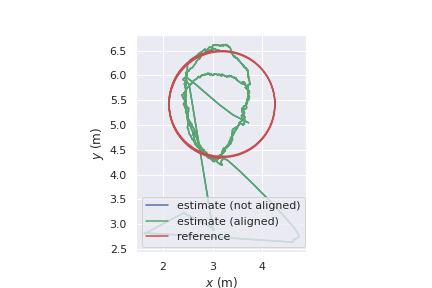

In [31]:
fig = plt.figure()
traj_by_label = {
    "estimate (not aligned)": traj_est,
    "estimate (aligned)": traj_est_aligned,
    "reference": traj_ref
}
plot.trajectories(fig, traj_by_label, plot.PlotMode.xy)
plt.show()